dice,▁
epoch,▁
iou,▁
precision,▁
recall,▁
train_loss,▁
val_loss,▁
dice,0.32941
epoch,1
iou,0.20192
precision,0.21569


Epoch [1/100] Train Loss: 1.2853 | Val Loss: 1.1634 | Dice: 0.4952 IoU: 0.3346 Prec: 0.4600 Recall: 0.5791
✅ Model saved!
Epoch [1/100] Train Loss: 1.2853 | Val Loss: 1.1634 | Dice: 0.4952 IoU: 0.3346 Prec: 0.4600 Recall: 0.5791


Epoch [2/100] Train Loss: 1.1186 | Val Loss: 1.1065 | Dice: 0.5557 IoU: 0.3956 Prec: 0.5466 Recall: 0.6181
✅ Model saved!
Epoch [2/100] Train Loss: 1.1186 | Val Loss: 1.1065 | Dice: 0.5557 IoU: 0.3956 Prec: 0.5466 Recall: 0.6181


Epoch [3/100] Train Loss: 1.0582 | Val Loss: 1.0671 | Dice: 0.5465 IoU: 0.3994 Prec: 0.7157 Recall: 0.4725
✅ Model saved!
Epoch [3/100] Train Loss: 1.0582 | Val Loss: 1.0671 | Dice: 0.5465 IoU: 0.3994 Prec: 0.7157 Recall: 0.4725


Epoch [4/100] Train Loss: 1.0205 | Val Loss: 1.0481 | Dice: 0.5447 IoU: 0.3930 Prec: 0.4790 Recall: 0.6742
✅ Model saved!
Epoch [4/100] Train Loss: 1.0205 | Val Loss: 1.0481 | Dice: 0.5447 IoU: 0.3930 Prec: 0.4790 Recall: 0.6742


Epoch [5/100] Train Loss: 0.9678 | Val Loss: 0.9679 | Dice: 0.5906 IoU: 0.4344 Prec: 0.5336 Recall: 0.7080
✅ Model saved!
Epoch [5/100] Train Loss: 0.9678 | Val Loss: 0.9679 | Dice: 0.5906 IoU: 0.4344 Prec: 0.5336 Recall: 0.7080


Epoch [6/100] Train Loss: 0.9262 | Val Loss: 0.9386 | Dice: 0.5924 IoU: 0.4348 Prec: 0.5331 Recall: 0.7063
✅ Model saved!
Epoch [6/100] Train Loss: 0.9262 | Val Loss: 0.9386 | Dice: 0.5924 IoU: 0.4348 Prec: 0.5331 Recall: 0.7063


Epoch [7/100] Train Loss: 0.8942 | Val Loss: 0.9022 | Dice: 0.6454 IoU: 0.4874 Prec: 0.6622 Recall: 0.6772
✅ Model saved!
Epoch [7/100] Train Loss: 0.8942 | Val Loss: 0.9022 | Dice: 0.6454 IoU: 0.4874 Prec: 0.6622 Recall: 0.6772


Epoch [8/100] Train Loss: 0.8504 | Val Loss: 0.8926 | Dice: 0.6254 IoU: 0.4727 Prec: 0.6309 Recall: 0.6568
✅ Model saved!
Epoch [8/100] Train Loss: 0.8504 | Val Loss: 0.8926 | Dice: 0.6254 IoU: 0.4727 Prec: 0.6309 Recall: 0.6568


Epoch [9/100] Train Loss: 0.8267 | Val Loss: 0.8887 | Dice: 0.5838 IoU: 0.4277 Prec: 0.5311 Recall: 0.7072
✅ Model saved!
Epoch [9/100] Train Loss: 0.8267 | Val Loss: 0.8887 | Dice: 0.5838 IoU: 0.4277 Prec: 0.5311 Recall: 0.7072


Epoch [10/100] Train Loss: 0.7869 | Val Loss: 0.8466 | Dice: 0.6259 IoU: 0.4726 Prec: 0.5964 Recall: 0.6952
✅ Model saved!
Epoch [10/100] Train Loss: 0.7869 | Val Loss: 0.8466 | Dice: 0.6259 IoU: 0.4726 Prec: 0.5964 Recall: 0.6952


Epoch [11/100] Train Loss: 0.7479 | Val Loss: 0.7908 | Dice: 0.6461 IoU: 0.4889 Prec: 0.6164 Recall: 0.7251
✅ Model saved!
Epoch [11/100] Train Loss: 0.7479 | Val Loss: 0.7908 | Dice: 0.6461 IoU: 0.4889 Prec: 0.6164 Recall: 0.7251


Epoch [12/100] Train Loss: 0.7098 | Val Loss: 0.8459 | Dice: 0.5988 IoU: 0.4385 Prec: 0.5785 Recall: 0.6825
Epoch [12/100] Train Loss: 0.7098 | Val Loss: 0.8459 | Dice: 0.5988 IoU: 0.4385 Prec: 0.5785 Recall: 0.6825


Epoch [13/100] Train Loss: 0.7123 | Val Loss: 0.7806 | Dice: 0.6248 IoU: 0.4654 Prec: 0.5984 Recall: 0.7017
✅ Model saved!
Epoch [13/100] Train Loss: 0.7123 | Val Loss: 0.7806 | Dice: 0.6248 IoU: 0.4654 Prec: 0.5984 Recall: 0.7017


Epoch [14/100] Train Loss: 0.6844 | Val Loss: 0.7538 | Dice: 0.6365 IoU: 0.4801 Prec: 0.6264 Recall: 0.6915
✅ Model saved!
Epoch [14/100] Train Loss: 0.6844 | Val Loss: 0.7538 | Dice: 0.6365 IoU: 0.4801 Prec: 0.6264 Recall: 0.6915


Epoch [15/100] Train Loss: 0.6365 | Val Loss: 0.7315 | Dice: 0.6662 IoU: 0.5125 Prec: 0.6959 Recall: 0.6764
✅ Model saved!
Epoch [15/100] Train Loss: 0.6365 | Val Loss: 0.7315 | Dice: 0.6662 IoU: 0.5125 Prec: 0.6959 Recall: 0.6764


Epoch [16/100] Train Loss: 0.6333 | Val Loss: 0.7626 | Dice: 0.6314 IoU: 0.4751 Prec: 0.5854 Recall: 0.7294
Epoch [16/100] Train Loss: 0.6333 | Val Loss: 0.7626 | Dice: 0.6314 IoU: 0.4751 Prec: 0.5854 Recall: 0.7294


Epoch [17/100] Train Loss: 0.6214 | Val Loss: 0.7149 | Dice: 0.6564 IoU: 0.5086 Prec: 0.6984 Recall: 0.6664
✅ Model saved!
Epoch [17/100] Train Loss: 0.6214 | Val Loss: 0.7149 | Dice: 0.6564 IoU: 0.5086 Prec: 0.6984 Recall: 0.6664


Epoch [18/100] Train Loss: 0.5740 | Val Loss: 0.6934 | Dice: 0.6802 IoU: 0.5287 Prec: 0.6455 Recall: 0.7642
✅ Model saved!
Epoch [18/100] Train Loss: 0.5740 | Val Loss: 0.6934 | Dice: 0.6802 IoU: 0.5287 Prec: 0.6455 Recall: 0.7642


Epoch [19/100] Train Loss: 0.5603 | Val Loss: 0.6716 | Dice: 0.6841 IoU: 0.5365 Prec: 0.7275 Recall: 0.6876
✅ Model saved!
Epoch [19/100] Train Loss: 0.5603 | Val Loss: 0.6716 | Dice: 0.6841 IoU: 0.5365 Prec: 0.7275 Recall: 0.6876


Epoch [20/100] Train Loss: 0.5438 | Val Loss: 0.7143 | Dice: 0.6450 IoU: 0.4862 Prec: 0.5989 Recall: 0.7399
Epoch [20/100] Train Loss: 0.5438 | Val Loss: 0.7143 | Dice: 0.6450 IoU: 0.4862 Prec: 0.5989 Recall: 0.7399


Epoch [21/100] Train Loss: 0.5467 | Val Loss: 0.6804 | Dice: 0.6654 IoU: 0.5068 Prec: 0.6124 Recall: 0.7777
Epoch [21/100] Train Loss: 0.5467 | Val Loss: 0.6804 | Dice: 0.6654 IoU: 0.5068 Prec: 0.6124 Recall: 0.7777


Epoch [22/100] Train Loss: 0.5266 | Val Loss: 0.6756 | Dice: 0.6731 IoU: 0.5209 Prec: 0.7095 Recall: 0.6899
Epoch [22/100] Train Loss: 0.5266 | Val Loss: 0.6756 | Dice: 0.6731 IoU: 0.5209 Prec: 0.7095 Recall: 0.6899


Epoch [23/100] Train Loss: 0.4954 | Val Loss: 0.6407 | Dice: 0.6987 IoU: 0.5516 Prec: 0.7248 Recall: 0.7206
✅ Model saved!
Epoch [23/100] Train Loss: 0.4954 | Val Loss: 0.6407 | Dice: 0.6987 IoU: 0.5516 Prec: 0.7248 Recall: 0.7206


Epoch [24/100] Train Loss: 0.4750 | Val Loss: 0.6127 | Dice: 0.7073 IoU: 0.5610 Prec: 0.7165 Recall: 0.7382
✅ Model saved!
Epoch [24/100] Train Loss: 0.4750 | Val Loss: 0.6127 | Dice: 0.7073 IoU: 0.5610 Prec: 0.7165 Recall: 0.7382


Epoch [25/100] Train Loss: 0.4666 | Val Loss: 0.6878 | Dice: 0.6505 IoU: 0.4995 Prec: 0.8307 Recall: 0.5726
Epoch [25/100] Train Loss: 0.4666 | Val Loss: 0.6878 | Dice: 0.6505 IoU: 0.4995 Prec: 0.8307 Recall: 0.5726


Epoch [26/100] Train Loss: 0.4668 | Val Loss: 0.6737 | Dice: 0.6508 IoU: 0.5032 Prec: 0.6735 Recall: 0.6859
Epoch [26/100] Train Loss: 0.4668 | Val Loss: 0.6737 | Dice: 0.6508 IoU: 0.5032 Prec: 0.6735 Recall: 0.6859


Epoch [27/100] Train Loss: 0.4591 | Val Loss: 0.6282 | Dice: 0.6811 IoU: 0.5326 Prec: 0.7598 Recall: 0.6546
Epoch [27/100] Train Loss: 0.4591 | Val Loss: 0.6282 | Dice: 0.6811 IoU: 0.5326 Prec: 0.7598 Recall: 0.6546


Epoch [28/100] Train Loss: 0.4457 | Val Loss: 0.6160 | Dice: 0.6959 IoU: 0.5498 Prec: 0.7079 Recall: 0.7329
Epoch [28/100] Train Loss: 0.4457 | Val Loss: 0.6160 | Dice: 0.6959 IoU: 0.5498 Prec: 0.7079 Recall: 0.7329


Epoch [29/100] Train Loss: 0.4411 | Val Loss: 0.6812 | Dice: 0.6647 IoU: 0.5159 Prec: 0.8312 Recall: 0.5811
Epoch [29/100] Train Loss: 0.4411 | Val Loss: 0.6812 | Dice: 0.6647 IoU: 0.5159 Prec: 0.8312 Recall: 0.5811


Epoch [30/100] Train Loss: 0.4414 | Val Loss: 0.6260 | Dice: 0.7022 IoU: 0.5583 Prec: 0.7931 Recall: 0.6766
Epoch [30/100] Train Loss: 0.4414 | Val Loss: 0.6260 | Dice: 0.7022 IoU: 0.5583 Prec: 0.7931 Recall: 0.6766


Epoch [31/100] Train Loss: 0.4069 | Val Loss: 0.6187 | Dice: 0.6981 IoU: 0.5521 Prec: 0.7065 Recall: 0.7313
Epoch [31/100] Train Loss: 0.4069 | Val Loss: 0.6187 | Dice: 0.6981 IoU: 0.5521 Prec: 0.7065 Recall: 0.7313


Epoch [32/100] Train Loss: 0.3984 | Val Loss: 0.5917 | Dice: 0.7145 IoU: 0.5690 Prec: 0.7605 Recall: 0.6971
✅ Model saved!
Epoch [32/100] Train Loss: 0.3984 | Val Loss: 0.5917 | Dice: 0.7145 IoU: 0.5690 Prec: 0.7605 Recall: 0.6971


Epoch [33/100] Train Loss: 0.3804 | Val Loss: 0.5644 | Dice: 0.7397 IoU: 0.5994 Prec: 0.7396 Recall: 0.7628
✅ Model saved!
Epoch [33/100] Train Loss: 0.3804 | Val Loss: 0.5644 | Dice: 0.7397 IoU: 0.5994 Prec: 0.7396 Recall: 0.7628


Epoch [34/100] Train Loss: 0.3819 | Val Loss: 0.5956 | Dice: 0.7190 IoU: 0.5781 Prec: 0.8161 Recall: 0.6810
Epoch [34/100] Train Loss: 0.3819 | Val Loss: 0.5956 | Dice: 0.7190 IoU: 0.5781 Prec: 0.8161 Recall: 0.6810


Epoch [35/100] Train Loss: 0.3892 | Val Loss: 0.5982 | Dice: 0.7137 IoU: 0.5651 Prec: 0.7307 Recall: 0.7264
Epoch [35/100] Train Loss: 0.3892 | Val Loss: 0.5982 | Dice: 0.7137 IoU: 0.5651 Prec: 0.7307 Recall: 0.7264


Epoch [36/100] Train Loss: 0.3894 | Val Loss: 0.6287 | Dice: 0.7082 IoU: 0.5652 Prec: 0.7786 Recall: 0.6690
Epoch [36/100] Train Loss: 0.3894 | Val Loss: 0.6287 | Dice: 0.7082 IoU: 0.5652 Prec: 0.7786 Recall: 0.6690


Epoch [37/100] Train Loss: 0.3783 | Val Loss: 0.6020 | Dice: 0.7216 IoU: 0.5788 Prec: 0.7727 Recall: 0.7155
Epoch [37/100] Train Loss: 0.3783 | Val Loss: 0.6020 | Dice: 0.7216 IoU: 0.5788 Prec: 0.7727 Recall: 0.7155


Epoch [38/100] Train Loss: 0.4165 | Val Loss: 0.6743 | Dice: 0.6474 IoU: 0.4868 Prec: 0.5957 Recall: 0.7438
Epoch [38/100] Train Loss: 0.4165 | Val Loss: 0.6743 | Dice: 0.6474 IoU: 0.4868 Prec: 0.5957 Recall: 0.7438


Epoch [39/100] Train Loss: 0.4230 | Val Loss: 0.6478 | Dice: 0.6824 IoU: 0.5295 Prec: 0.7484 Recall: 0.6549
Epoch [39/100] Train Loss: 0.4230 | Val Loss: 0.6478 | Dice: 0.6824 IoU: 0.5295 Prec: 0.7484 Recall: 0.6549


Epoch [40/100] Train Loss: 0.3864 | Val Loss: 0.5803 | Dice: 0.7213 IoU: 0.5774 Prec: 0.7480 Recall: 0.7241
Epoch [40/100] Train Loss: 0.3864 | Val Loss: 0.5803 | Dice: 0.7213 IoU: 0.5774 Prec: 0.7480 Recall: 0.7241


Epoch [41/100] Train Loss: 0.3651 | Val Loss: 0.5871 | Dice: 0.7275 IoU: 0.5845 Prec: 0.8156 Recall: 0.6880
Epoch [41/100] Train Loss: 0.3651 | Val Loss: 0.5871 | Dice: 0.7275 IoU: 0.5845 Prec: 0.8156 Recall: 0.6880


Epoch [42/100] Train Loss: 0.3544 | Val Loss: 0.5759 | Dice: 0.7334 IoU: 0.5907 Prec: 0.7179 Recall: 0.7830
Epoch [42/100] Train Loss: 0.3544 | Val Loss: 0.5759 | Dice: 0.7334 IoU: 0.5907 Prec: 0.7179 Recall: 0.7830


Epoch [43/100] Train Loss: 0.3292 | Val Loss: 0.5767 | Dice: 0.7392 IoU: 0.5996 Prec: 0.8096 Recall: 0.7131
Epoch [43/100] Train Loss: 0.3292 | Val Loss: 0.5767 | Dice: 0.7392 IoU: 0.5996 Prec: 0.8096 Recall: 0.7131


Epoch [44/100] Train Loss: 0.3377 | Val Loss: 0.6256 | Dice: 0.7070 IoU: 0.5624 Prec: 0.8095 Recall: 0.6663
Epoch [44/100] Train Loss: 0.3377 | Val Loss: 0.6256 | Dice: 0.7070 IoU: 0.5624 Prec: 0.8095 Recall: 0.6663


Epoch [45/100] Train Loss: 0.3310 | Val Loss: 0.5507 | Dice: 0.7492 IoU: 0.6102 Prec: 0.7829 Recall: 0.7494
✅ Model saved!
Epoch [45/100] Train Loss: 0.3310 | Val Loss: 0.5507 | Dice: 0.7492 IoU: 0.6102 Prec: 0.7829 Recall: 0.7494


Epoch [46/100] Train Loss: 0.3071 | Val Loss: 0.5596 | Dice: 0.7521 IoU: 0.6132 Prec: 0.7897 Recall: 0.7469
Epoch [46/100] Train Loss: 0.3071 | Val Loss: 0.5596 | Dice: 0.7521 IoU: 0.6132 Prec: 0.7897 Recall: 0.7469


Epoch [47/100] Train Loss: 0.3081 | Val Loss: 0.5565 | Dice: 0.7470 IoU: 0.6067 Prec: 0.7876 Recall: 0.7412
Epoch [47/100] Train Loss: 0.3081 | Val Loss: 0.5565 | Dice: 0.7470 IoU: 0.6067 Prec: 0.7876 Recall: 0.7412


Epoch [48/100] Train Loss: 0.3033 | Val Loss: 0.5586 | Dice: 0.7487 IoU: 0.6089 Prec: 0.7861 Recall: 0.7458
Epoch [48/100] Train Loss: 0.3033 | Val Loss: 0.5586 | Dice: 0.7487 IoU: 0.6089 Prec: 0.7861 Recall: 0.7458


Epoch [49/100] Train Loss: 0.2961 | Val Loss: 0.5537 | Dice: 0.7489 IoU: 0.6089 Prec: 0.7917 Recall: 0.7402
Epoch [49/100] Train Loss: 0.2961 | Val Loss: 0.5537 | Dice: 0.7489 IoU: 0.6089 Prec: 0.7917 Recall: 0.7402


Epoch [50/100] Train Loss: 0.2959 | Val Loss: 0.5673 | Dice: 0.7404 IoU: 0.5978 Prec: 0.7548 Recall: 0.7541
Epoch [50/100] Train Loss: 0.2959 | Val Loss: 0.5673 | Dice: 0.7404 IoU: 0.5978 Prec: 0.7548 Recall: 0.7541


Epoch [51/100] Train Loss: 0.2961 | Val Loss: 0.5645 | Dice: 0.7478 IoU: 0.6076 Prec: 0.8085 Recall: 0.7221
Epoch [51/100] Train Loss: 0.2961 | Val Loss: 0.5645 | Dice: 0.7478 IoU: 0.6076 Prec: 0.8085 Recall: 0.7221


Epoch [52/100] Train Loss: 0.2924 | Val Loss: 0.5764 | Dice: 0.7429 IoU: 0.6022 Prec: 0.7996 Recall: 0.7179
Epoch [52/100] Train Loss: 0.2924 | Val Loss: 0.5764 | Dice: 0.7429 IoU: 0.6022 Prec: 0.7996 Recall: 0.7179


Epoch [53/100] Train Loss: 0.2883 | Val Loss: 0.5671 | Dice: 0.7441 IoU: 0.6027 Prec: 0.7554 Recall: 0.7664
Epoch [53/100] Train Loss: 0.2883 | Val Loss: 0.5671 | Dice: 0.7441 IoU: 0.6027 Prec: 0.7554 Recall: 0.7664


Epoch [54/100] Train Loss: 0.2935 | Val Loss: 0.5762 | Dice: 0.7418 IoU: 0.6009 Prec: 0.7883 Recall: 0.7290
Epoch [54/100] Train Loss: 0.2935 | Val Loss: 0.5762 | Dice: 0.7418 IoU: 0.6009 Prec: 0.7883 Recall: 0.7290


Epoch [55/100] Train Loss: 0.2995 | Val Loss: 0.5727 | Dice: 0.7430 IoU: 0.6024 Prec: 0.8158 Recall: 0.7082
Epoch [55/100] Train Loss: 0.2995 | Val Loss: 0.5727 | Dice: 0.7430 IoU: 0.6024 Prec: 0.8158 Recall: 0.7082


Epoch [56/100] Train Loss: 0.2894 | Val Loss: 0.5627 | Dice: 0.7529 IoU: 0.6131 Prec: 0.7783 Recall: 0.7641
Epoch [56/100] Train Loss: 0.2894 | Val Loss: 0.5627 | Dice: 0.7529 IoU: 0.6131 Prec: 0.7783 Recall: 0.7641


Epoch [57/100] Train Loss: 0.2782 | Val Loss: 0.5713 | Dice: 0.7484 IoU: 0.6081 Prec: 0.8096 Recall: 0.7234
Epoch [57/100] Train Loss: 0.2782 | Val Loss: 0.5713 | Dice: 0.7484 IoU: 0.6081 Prec: 0.8096 Recall: 0.7234


Epoch [58/100] Train Loss: 0.2731 | Val Loss: 0.5730 | Dice: 0.7417 IoU: 0.6004 Prec: 0.7997 Recall: 0.7208
Epoch [58/100] Train Loss: 0.2731 | Val Loss: 0.5730 | Dice: 0.7417 IoU: 0.6004 Prec: 0.7997 Recall: 0.7208


Epoch [59/100] Train Loss: 0.2691 | Val Loss: 0.5724 | Dice: 0.7427 IoU: 0.6019 Prec: 0.7981 Recall: 0.7237
Epoch [59/100] Train Loss: 0.2691 | Val Loss: 0.5724 | Dice: 0.7427 IoU: 0.6019 Prec: 0.7981 Recall: 0.7237


Epoch [60/100] Train Loss: 0.2719 | Val Loss: 0.5748 | Dice: 0.7430 IoU: 0.6019 Prec: 0.7903 Recall: 0.7311
Epoch [60/100] Train Loss: 0.2719 | Val Loss: 0.5748 | Dice: 0.7430 IoU: 0.6019 Prec: 0.7903 Recall: 0.7311


Epoch [61/100] Train Loss: 0.2671 | Val Loss: 0.5624 | Dice: 0.7470 IoU: 0.6068 Prec: 0.7839 Recall: 0.7428
Epoch [61/100] Train Loss: 0.2671 | Val Loss: 0.5624 | Dice: 0.7470 IoU: 0.6068 Prec: 0.7839 Recall: 0.7428


Epoch [62/100] Train Loss: 0.2649 | Val Loss: 0.5898 | Dice: 0.7465 IoU: 0.6063 Prec: 0.8018 Recall: 0.7286
Epoch [62/100] Train Loss: 0.2649 | Val Loss: 0.5898 | Dice: 0.7465 IoU: 0.6063 Prec: 0.8018 Recall: 0.7286


Epoch [63/100] Train Loss: 0.2666 | Val Loss: 0.5850 | Dice: 0.7450 IoU: 0.6047 Prec: 0.7957 Recall: 0.7333
Epoch [63/100] Train Loss: 0.2666 | Val Loss: 0.5850 | Dice: 0.7450 IoU: 0.6047 Prec: 0.7957 Recall: 0.7333


Epoch [64/100] Train Loss: 0.2633 | Val Loss: 0.5784 | Dice: 0.7456 IoU: 0.6048 Prec: 0.7952 Recall: 0.7308
Epoch [64/100] Train Loss: 0.2633 | Val Loss: 0.5784 | Dice: 0.7456 IoU: 0.6048 Prec: 0.7952 Recall: 0.7308


Epoch [65/100] Train Loss: 0.2601 | Val Loss: 0.5763 | Dice: 0.7461 IoU: 0.6053 Prec: 0.7921 Recall: 0.7367
Epoch [65/100] Train Loss: 0.2601 | Val Loss: 0.5763 | Dice: 0.7461 IoU: 0.6053 Prec: 0.7921 Recall: 0.7367


Epoch [66/100] Train Loss: 0.2610 | Val Loss: 0.5779 | Dice: 0.7413 IoU: 0.6002 Prec: 0.7997 Recall: 0.7192
Epoch [66/100] Train Loss: 0.2610 | Val Loss: 0.5779 | Dice: 0.7413 IoU: 0.6002 Prec: 0.7997 Recall: 0.7192


Epoch [67/100] Train Loss: 0.2583 | Val Loss: 0.5710 | Dice: 0.7471 IoU: 0.6061 Prec: 0.7924 Recall: 0.7357
Epoch [67/100] Train Loss: 0.2583 | Val Loss: 0.5710 | Dice: 0.7471 IoU: 0.6061 Prec: 0.7924 Recall: 0.7357


Epoch [68/100] Train Loss: 0.2539 | Val Loss: 0.5788 | Dice: 0.7405 IoU: 0.5984 Prec: 0.7894 Recall: 0.7252
Epoch [68/100] Train Loss: 0.2539 | Val Loss: 0.5788 | Dice: 0.7405 IoU: 0.5984 Prec: 0.7894 Recall: 0.7252


Epoch [69/100] Train Loss: 0.2532 | Val Loss: 0.5813 | Dice: 0.7413 IoU: 0.5999 Prec: 0.8010 Recall: 0.7176
Epoch [69/100] Train Loss: 0.2532 | Val Loss: 0.5813 | Dice: 0.7413 IoU: 0.5999 Prec: 0.8010 Recall: 0.7176


Epoch [70/100] Train Loss: 0.2526 | Val Loss: 0.5721 | Dice: 0.7445 IoU: 0.6034 Prec: 0.7973 Recall: 0.7260
Epoch [70/100] Train Loss: 0.2526 | Val Loss: 0.5721 | Dice: 0.7445 IoU: 0.6034 Prec: 0.7973 Recall: 0.7260


Epoch [71/100] Train Loss: 0.2517 | Val Loss: 0.5819 | Dice: 0.7418 IoU: 0.6009 Prec: 0.8029 Recall: 0.7176
Epoch [71/100] Train Loss: 0.2517 | Val Loss: 0.5819 | Dice: 0.7418 IoU: 0.6009 Prec: 0.8029 Recall: 0.7176


Epoch [72/100] Train Loss: 0.2508 | Val Loss: 0.5789 | Dice: 0.7433 IoU: 0.6014 Prec: 0.7805 Recall: 0.7378
Epoch [72/100] Train Loss: 0.2508 | Val Loss: 0.5789 | Dice: 0.7433 IoU: 0.6014 Prec: 0.7805 Recall: 0.7378


Epoch [73/100] Train Loss: 0.2524 | Val Loss: 0.5779 | Dice: 0.7441 IoU: 0.6027 Prec: 0.7812 Recall: 0.7410
Epoch [73/100] Train Loss: 0.2524 | Val Loss: 0.5779 | Dice: 0.7441 IoU: 0.6027 Prec: 0.7812 Recall: 0.7410


Epoch [74/100] Train Loss: 0.2518 | Val Loss: 0.5798 | Dice: 0.7404 IoU: 0.5982 Prec: 0.7920 Recall: 0.7238
Epoch [74/100] Train Loss: 0.2518 | Val Loss: 0.5798 | Dice: 0.7404 IoU: 0.5982 Prec: 0.7920 Recall: 0.7238


Epoch [75/100] Train Loss: 0.2502 | Val Loss: 0.5824 | Dice: 0.7430 IoU: 0.6018 Prec: 0.8052 Recall: 0.7168
Epoch [75/100] Train Loss: 0.2502 | Val Loss: 0.5824 | Dice: 0.7430 IoU: 0.6018 Prec: 0.8052 Recall: 0.7168


Epoch [76/100] Train Loss: 0.2482 | Val Loss: 0.5836 | Dice: 0.7398 IoU: 0.5976 Prec: 0.7934 Recall: 0.7194
Epoch [76/100] Train Loss: 0.2482 | Val Loss: 0.5836 | Dice: 0.7398 IoU: 0.5976 Prec: 0.7934 Recall: 0.7194


Epoch [77/100] Train Loss: 0.2470 | Val Loss: 0.5843 | Dice: 0.7404 IoU: 0.5985 Prec: 0.7945 Recall: 0.7223
Epoch [77/100] Train Loss: 0.2470 | Val Loss: 0.5843 | Dice: 0.7404 IoU: 0.5985 Prec: 0.7945 Recall: 0.7223


Epoch [78/100] Train Loss: 0.2455 | Val Loss: 0.5820 | Dice: 0.7422 IoU: 0.6012 Prec: 0.8066 Recall: 0.7143
Epoch [78/100] Train Loss: 0.2455 | Val Loss: 0.5820 | Dice: 0.7422 IoU: 0.6012 Prec: 0.8066 Recall: 0.7143


Epoch [79/100] Train Loss: 0.2447 | Val Loss: 0.5837 | Dice: 0.7402 IoU: 0.5984 Prec: 0.7931 Recall: 0.7218
Epoch [79/100] Train Loss: 0.2447 | Val Loss: 0.5837 | Dice: 0.7402 IoU: 0.5984 Prec: 0.7931 Recall: 0.7218


Epoch [80/100] Train Loss: 0.2438 | Val Loss: 0.5846 | Dice: 0.7431 IoU: 0.6017 Prec: 0.7923 Recall: 0.7274
Epoch [80/100] Train Loss: 0.2438 | Val Loss: 0.5846 | Dice: 0.7431 IoU: 0.6017 Prec: 0.7923 Recall: 0.7274


Epoch [81/100] Train Loss: 0.2423 | Val Loss: 0.5905 | Dice: 0.7401 IoU: 0.5983 Prec: 0.7983 Recall: 0.7175
Epoch [81/100] Train Loss: 0.2423 | Val Loss: 0.5905 | Dice: 0.7401 IoU: 0.5983 Prec: 0.7983 Recall: 0.7175


Epoch [82/100] Train Loss: 0.2434 | Val Loss: 0.5921 | Dice: 0.7395 IoU: 0.5972 Prec: 0.7947 Recall: 0.7203
Epoch [82/100] Train Loss: 0.2434 | Val Loss: 0.5921 | Dice: 0.7395 IoU: 0.5972 Prec: 0.7947 Recall: 0.7203


Epoch [83/100] Train Loss: 0.2422 | Val Loss: 0.5875 | Dice: 0.7401 IoU: 0.5982 Prec: 0.7894 Recall: 0.7256
Epoch [83/100] Train Loss: 0.2422 | Val Loss: 0.5875 | Dice: 0.7401 IoU: 0.5982 Prec: 0.7894 Recall: 0.7256


Epoch [84/100] Train Loss: 0.2416 | Val Loss: 0.5924 | Dice: 0.7384 IoU: 0.5962 Prec: 0.8016 Recall: 0.7124
Epoch [84/100] Train Loss: 0.2416 | Val Loss: 0.5924 | Dice: 0.7384 IoU: 0.5962 Prec: 0.8016 Recall: 0.7124


Epoch [85/100] Train Loss: 0.2415 | Val Loss: 0.5885 | Dice: 0.7406 IoU: 0.5985 Prec: 0.7903 Recall: 0.7261
Epoch [85/100] Train Loss: 0.2415 | Val Loss: 0.5885 | Dice: 0.7406 IoU: 0.5985 Prec: 0.7903 Recall: 0.7261


Epoch [86/100] Train Loss: 0.2413 | Val Loss: 0.5975 | Dice: 0.7360 IoU: 0.5933 Prec: 0.7964 Recall: 0.7133
Epoch [86/100] Train Loss: 0.2413 | Val Loss: 0.5975 | Dice: 0.7360 IoU: 0.5933 Prec: 0.7964 Recall: 0.7133


Epoch [87/100] Train Loss: 0.2408 | Val Loss: 0.5926 | Dice: 0.7387 IoU: 0.5965 Prec: 0.7881 Recall: 0.7247
Epoch [87/100] Train Loss: 0.2408 | Val Loss: 0.5926 | Dice: 0.7387 IoU: 0.5965 Prec: 0.7881 Recall: 0.7247


Epoch [88/100] Train Loss: 0.2399 | Val Loss: 0.5985 | Dice: 0.7374 IoU: 0.5946 Prec: 0.7920 Recall: 0.7183
Epoch [88/100] Train Loss: 0.2399 | Val Loss: 0.5985 | Dice: 0.7374 IoU: 0.5946 Prec: 0.7920 Recall: 0.7183


Epoch [89/100] Train Loss: 0.2402 | Val Loss: 0.6002 | Dice: 0.7360 IoU: 0.5932 Prec: 0.7942 Recall: 0.7146
Epoch [89/100] Train Loss: 0.2402 | Val Loss: 0.6002 | Dice: 0.7360 IoU: 0.5932 Prec: 0.7942 Recall: 0.7146


Epoch [90/100] Train Loss: 0.2391 | Val Loss: 0.5934 | Dice: 0.7372 IoU: 0.5943 Prec: 0.7953 Recall: 0.7154
Epoch [90/100] Train Loss: 0.2391 | Val Loss: 0.5934 | Dice: 0.7372 IoU: 0.5943 Prec: 0.7953 Recall: 0.7154


Epoch [91/100] Train Loss: 0.2382 | Val Loss: 0.5966 | Dice: 0.7370 IoU: 0.5942 Prec: 0.7977 Recall: 0.7141
Epoch [91/100] Train Loss: 0.2382 | Val Loss: 0.5966 | Dice: 0.7370 IoU: 0.5942 Prec: 0.7977 Recall: 0.7141


Epoch [92/100] Train Loss: 0.2384 | Val Loss: 0.5938 | Dice: 0.7373 IoU: 0.5943 Prec: 0.7943 Recall: 0.7165
Epoch [92/100] Train Loss: 0.2384 | Val Loss: 0.5938 | Dice: 0.7373 IoU: 0.5943 Prec: 0.7943 Recall: 0.7165


Epoch [93/100] Train Loss: 0.2372 | Val Loss: 0.5992 | Dice: 0.7373 IoU: 0.5947 Prec: 0.7863 Recall: 0.7226
Epoch [93/100] Train Loss: 0.2372 | Val Loss: 0.5992 | Dice: 0.7373 IoU: 0.5947 Prec: 0.7863 Recall: 0.7226


Epoch [94/100] Train Loss: 0.2376 | Val Loss: 0.5985 | Dice: 0.7373 IoU: 0.5947 Prec: 0.7923 Recall: 0.7184
Epoch [94/100] Train Loss: 0.2376 | Val Loss: 0.5985 | Dice: 0.7373 IoU: 0.5947 Prec: 0.7923 Recall: 0.7184


Epoch [95/100] Train Loss: 0.2367 | Val Loss: 0.5989 | Dice: 0.7360 IoU: 0.5931 Prec: 0.7901 Recall: 0.7174
Epoch [95/100] Train Loss: 0.2367 | Val Loss: 0.5989 | Dice: 0.7360 IoU: 0.5931 Prec: 0.7901 Recall: 0.7174


Epoch [96/100] Train Loss: 0.2357 | Val Loss: 0.6004 | Dice: 0.7362 IoU: 0.5933 Prec: 0.7910 Recall: 0.7172
Epoch [96/100] Train Loss: 0.2357 | Val Loss: 0.6004 | Dice: 0.7362 IoU: 0.5933 Prec: 0.7910 Recall: 0.7172


Epoch [97/100] Train Loss: 0.2354 | Val Loss: 0.6043 | Dice: 0.7339 IoU: 0.5903 Prec: 0.7936 Recall: 0.7111
Epoch [97/100] Train Loss: 0.2354 | Val Loss: 0.6043 | Dice: 0.7339 IoU: 0.5903 Prec: 0.7936 Recall: 0.7111


Epoch [98/100] Train Loss: 0.2359 | Val Loss: 0.5979 | Dice: 0.7395 IoU: 0.5977 Prec: 0.7899 Recall: 0.7246
Epoch [98/100] Train Loss: 0.2359 | Val Loss: 0.5979 | Dice: 0.7395 IoU: 0.5977 Prec: 0.7899 Recall: 0.7246


Epoch [99/100] Train Loss: 0.2362 | Val Loss: 0.5990 | Dice: 0.7371 IoU: 0.5944 Prec: 0.7955 Recall: 0.7155
Epoch [99/100] Train Loss: 0.2362 | Val Loss: 0.5990 | Dice: 0.7371 IoU: 0.5944 Prec: 0.7955 Recall: 0.7155


Epoch [100/100] Train Loss: 0.2347 | Val Loss: 0.6057 | Dice: 0.7346 IoU: 0.5916 Prec: 0.7943 Recall: 0.7117
Epoch [100/100] Train Loss: 0.2347 | Val Loss: 0.6057 | Dice: 0.7346 IoU: 0.5916 Prec: 0.7943 Recall: 0.7117


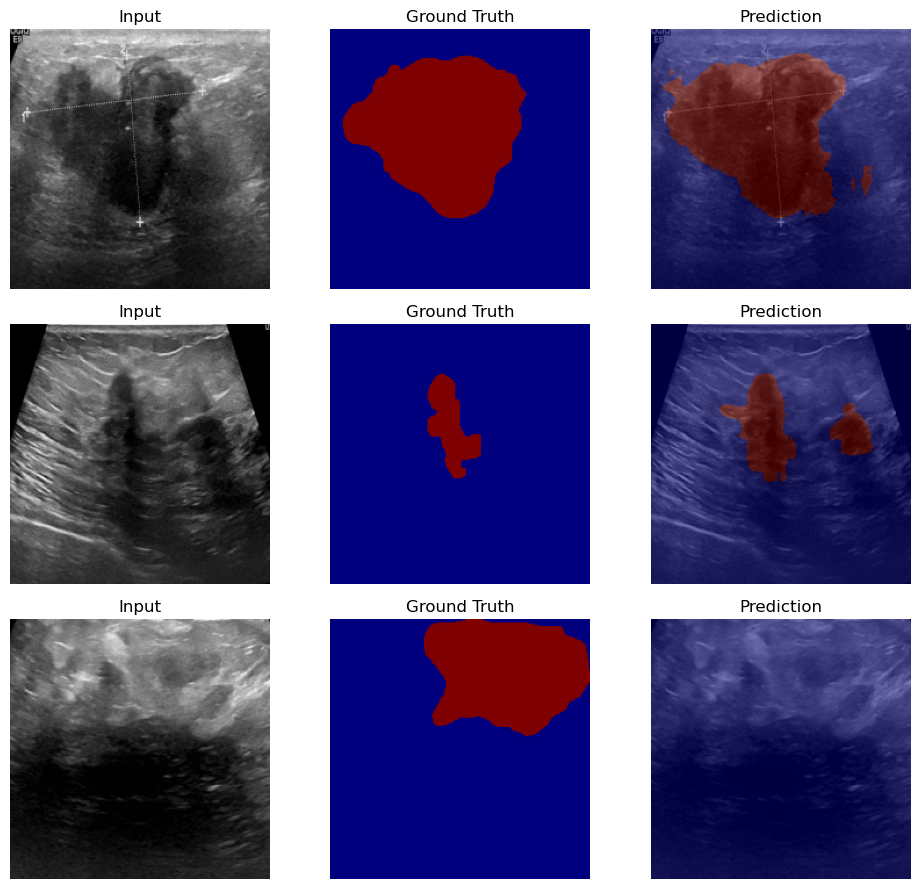

In [8]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import wandb

# ===========================
# Repro (optional)
# ===========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# ===========================
# Dataset
# ===========================
class BUSIDataset(Dataset):
    def __init__(self, series, transform=None):
        self.series = series
        self.transform = transform

    def __len__(self):
        return len(self.series)

    def __getitem__(self, idx):
        img_path, mask_path = self.series[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # BUSI is grayscale
        mask  = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        mask  = cv2.resize(mask,  (224, 224), interpolation=cv2.INTER_NEAREST)

        image = np.expand_dims(image, axis=-1)
        mask  = np.expand_dims((mask > 0).astype(np.uint8), axis=-1)  # ensure {0,1}

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask  = torch.tensor(mask,  dtype=torch.float32).permute(2, 0, 1)       # already 0/1

        return image, mask


# ===========================
# BitNet core
# ===========================
class BitLinear(nn.Linear):
    """
    Binary (tanh-binarized) Linear with per-output-channel scale (alpha).
    y = x @ (alpha * tanh(W))^T + b
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        # Per-output scaling: shape (out, 1)
        self.alpha = nn.Parameter(torch.ones(out_features, 1))

        # Init: small weights help stability
        nn.init.normal_(self.weight, std=0.02)
        if bias:
            nn.init.zeros_(self.bias)

    def forward(self, x):
        # Smooth "binary" proxy with tanh keeps gradient flow
        w_bin = torch.tanh(self.weight) * self.alpha
        return F.linear(x, w_bin, self.bias)


class BitMLP(nn.Module):
    def __init__(self, dim, hidden_dim, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        self.fc1  = BitLinear(dim, hidden_dim, bias=True)
        self.act  = act_layer()
        self.drop = nn.Dropout(drop)
        self.fc2  = BitLinear(hidden_dim, dim, bias=True)

    def forward(self, x):  # (B, N, C)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, win):
    # x: (B, H, W, C) -> (B*nw, win, win, C)
    B, H, W, C = x.shape
    x = x.view(B, H // win, win, W // win, win, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, win, win, C)
    return x

def window_reverse(windows, win, H, W):
    # windows: (B*nw, win, win, C) -> (B, H, W, C)
    Bn, _, _, C = windows.shape
    B = Bn // ((H // win) * (W // win))
    x = windows.view(B, H // win, W // win, win, win, C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, C)
    return x


class BitMultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.window_size = window_size

        self.qkv = BitLinear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = BitLinear(dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward_tokens(self, x):  # x: (B, N, C)
        B, N, C = x.shape
        qkv = self.qkv(x).view(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.unbind(dim=2)           # (B, N, H, D)
        q = q.transpose(1, 2)                 # (B, H, N, D)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, H, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape
        if self.window_size is None:
            t = x.flatten(2).transpose(1, 2)      # (B, N, C)
            t = self.forward_tokens(t)
            t = t.transpose(1, 2).view(B, C, H, W)
            return t
        else:
            win = self.window_size
            assert H % win == 0 and W % win == 0, "H/W must be divisible by window_size"
            t = x.permute(0, 2, 3, 1).contiguous()    # (B, H, W, C)
            windows = window_partition(t, win)        # (Bn, win, win, C)
            Bn = windows.shape[0]
            tokens = windows.view(Bn, win * win, C)   # (Bn, Nw, C)
            tokens = self.forward_tokens(tokens)
            windows = tokens.view(Bn, win, win, C)
            t = window_reverse(windows, win, H, W)    # (B, H, W, C)
            t = t.permute(0, 3, 1, 2).contiguous()    # (B, C, H, W)
            return t


class BitSwinBlockFull(nn.Module):
    """
    LN -> Bit-MHSA -> +res -> LN -> Bit-MLP -> +res
    Works on (B, C, H, W). Optional window attention via window_size.
    """
    def __init__(self, dim, num_heads=8, mlp_ratio=4.0, window_size=None, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = BitMultiHeadSelfAttention(dim, num_heads=num_heads, window_size=window_size,
                                               attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = BitMLP(dim, hidden, act_layer=nn.GELU, drop=drop)

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape
        t = x.flatten(2).transpose(1, 2)  # (B, N, C)
        t = self.norm1(t)
        t = t.transpose(1, 2).view(B, C, H, W)
        x = x + self.attn(t)

        t = x.flatten(2).transpose(1, 2)
        t = self.norm2(t)
        t = self.mlp(t)
        t = t.transpose(1, 2).view(B, C, H, W)
        x = x + t
        return x


# ===========================
# UNet blocks
# ===========================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)


def make_bitswin_stack(channels, depth, heads, window):
    """Create a stack (Sequential) of BitSwin blocks for a stage."""
    return nn.Sequential(*[
        BitSwinBlockFull(channels, num_heads=heads, window_size=window)
        for _ in range(depth)
    ]) if depth > 0 else nn.Identity()


class BitSwinUNet(nn.Module):
    """
    A UNet with optional BitSwin (binary transformer) stacks at each encoder/decoder stage,
    plus a BitSwin bottleneck stack.
    """
    def __init__(
        self,
        img_size=224,
        in_ch=1,
        num_classes=1,
        base_ch=64,
        # depths: number of BitSwin blocks after each stage
        enc_bitswin_depths=(0, 1, 1, 2),  # after enc1..enc4 (enc1 default 0)
        dec_bitswin_depths=(1, 1, 0),     # after dec3, dec2, dec1
        bottleneck_blocks=2,
        heads=(4, 4, 8, 8),               # heads per stage (enc/dec share by resolution)
        bottleneck_heads=8,
        window=7                           # window size for local attention (divides stage H/W)
    ):
        super().__init__()
        # Encoder convs
        self.enc1 = ConvBlock(in_ch, base_ch)             # 224x224
        self.enc2 = ConvBlock(base_ch, base_ch * 2)       # 112x112
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)   # 56x56
        self.enc4 = ConvBlock(base_ch * 4, base_ch * 8)   # 28x28
        self.pool = nn.MaxPool2d(2)

        # BitSwin stacks after encoder convs
        self.enc1_bits = make_bitswin_stack(base_ch,       enc_bitswin_depths[0], heads[0], window)
        self.enc2_bits = make_bitswin_stack(base_ch * 2,   enc_bitswin_depths[1], heads[1], window)
        self.enc3_bits = make_bitswin_stack(base_ch * 4,   enc_bitswin_depths[2], heads[2], window)
        self.enc4_bits = make_bitswin_stack(base_ch * 8,   enc_bitswin_depths[3], heads[3], window)

        # Bottleneck (28x28 for 224 input)
        self.bottleneck = make_bitswin_stack(base_ch * 8, bottleneck_blocks, bottleneck_heads, window)

        # Decoder
        self.up3  = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)   # 28->56
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4)
        self.dec3_bits = make_bitswin_stack(base_ch * 4, dec_bitswin_depths[0], heads[2], window)

        self.up2  = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)   # 56->112
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)
        self.dec2_bits = make_bitswin_stack(base_ch * 2, dec_bitswin_depths[1], heads[1], window)

        self.up1  = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)       # 112->224
        self.dec1 = ConvBlock(base_ch * 2, base_ch)
        self.dec1_bits = make_bitswin_stack(base_ch,       dec_bitswin_depths[2], heads[0], window)

        self.final = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1 = self.enc1_bits(e1)

        e2 = self.enc2(self.pool(e1))
        e2 = self.enc2_bits(e2)

        e3 = self.enc3(self.pool(e2))
        e3 = self.enc3_bits(e3)

        e4 = self.enc4(self.pool(e3))
        e4 = self.enc4_bits(e4)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d3 = self.dec3_bits(d3)

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d2 = self.dec2_bits(d2)

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        d1 = self.dec1_bits(d1)

        out = self.final(d1)
        return out


# ===========================
# Losses
# ===========================
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum(dim=(2,3)) + smooth
    den = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth
    return 1 - (num / den).mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bw  = bce_weight
        self.dw  = dice_weight
    def forward(self, preds, targets):
        return self.bw * self.bce(preds, targets) + self.dw * dice_loss(preds, targets)


# ===========================
# Metrics
# ===========================
def compute_metrics(preds, masks, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2. * intersection) / (union + 1e-6)
    iou = intersection / (preds.sum() + masks.sum() - intersection + 1e-6)
    precision = intersection / (preds.sum() + 1e-6)
    recall = intersection / (masks.sum() + 1e-6)
    return dice.item(), iou.item(), precision.item(), recall.item()


# ===========================
# Visualization
# ===========================
def visualize_results(model, dataset, device="cuda", num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples*3))
    if num_samples == 1: axs = [axs]
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(img_in)).cpu().squeeze().numpy()
        img_np  = img.squeeze().numpy()
        mask_np = mask.squeeze().numpy()
        pred_np = (pred > 0.5).astype(np.uint8)
        axs[i][0].imshow(img_np, cmap="gray"); axs[i][0].set_title("Input")
        axs[i][1].imshow(mask_np, cmap="jet"); axs[i][1].set_title("Ground Truth")
        axs[i][2].imshow(img_np, cmap="gray"); axs[i][2].imshow(pred_np, cmap="jet", alpha=0.5); axs[i][2].set_title("Prediction")
        for ax in axs[i]: ax.axis("off")
    plt.tight_layout(); plt.show()


# ===========================
# Training Loop
# ===========================
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device="cuda", scheduler=None):
    wandb.init(project="bitnet-swin-unet", name="bitswin-unet-run")
    wandb.watch(model, log="all", log_freq=10)
    model.to(device)
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        avg_train_loss = train_loss / max(1, len(train_loader))

        # Validation
        model.eval()
        val_loss, dice, iou, precision, recall = 0.0, 0, 0, 0, 0
        vbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for imgs, masks in vbar:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                val_loss += loss.item()
                d, i, p, r = compute_metrics(preds, masks)
                dice += d; iou += i; precision += p; recall += r
        n_batches = max(1, len(val_loader))
        avg_val_loss = val_loss / n_batches
        avg_dice     = dice / n_batches
        avg_iou      = iou / n_batches
        avg_prec     = precision / n_batches
        avg_rec      = recall / n_batches

        # wandb logging
        wandb.log({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "dice": avg_dice,
            "iou": avg_iou,
            "precision": avg_prec,
            "recall": avg_rec
        })

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Dice: {avg_dice:.4f} IoU: {avg_iou:.4f} "
              f"Prec: {avg_prec:.4f} Recall: {avg_rec:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_bitswin_unet.pth")
            print("✅ Model saved!")
            #wandb.save("best_bitswin_unet.pth")

        # -----------------------
        # Scheduler step
        # -----------------------
        if scheduler is not None:
            if "ReduceLROnPlateau" in str(type(scheduler)):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # -----------------------
        # Print Epoch Summary
        # -----------------------
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Dice: {avg_dice:.4f} IoU: {avg_iou:.4f} "
              f"Prec: {avg_prec:.4f} Recall: {avg_rec:.4f}")

        # -----------------------
        # Save best model
        # -----------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_bitswin_unet.pth")
            print("✅ Model saved!")



# ===========================
# MAIN
# ===========================
if __name__ == "__main__":
    # Gather image/mask pairs
    masks = glob.glob("Dataset_BUSI_with_GT/*/*_mask.png")
    images = [m.replace("_mask", "") for m in masks]
    series = [(img, m) for img, m in zip(images, masks) if os.path.exists(img)]

    # Split
    train_series, val_series = train_test_split(series, test_size=0.2, random_state=42, shuffle=True)

    # Datasets / Loaders
    train_dataset = BUSIDataset(train_series)
    val_dataset   = BUSIDataset(val_series)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
    # Model
    # For 224x224 with three pools, e4/bottleneck features are 28x28 — window=7 divides cleanly.
    model = BitSwinUNet(
        img_size=224, in_ch=1, num_classes=1, base_ch=64,
        enc_bitswin_depths=(0, 1, 1, 2),
        dec_bitswin_depths=(1, 1, 0),
        bottleneck_blocks=2,
        heads=(4, 4, 8, 8),
        bottleneck_heads=8,
        window=7
    )

    # Loss / Optim / (optional) Scheduler
    criterion = BCEDiceLoss(bce_weight=1.0, dice_weight=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    # Train
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, device=device, scheduler=scheduler)

    # Visualize a few predictions
    visualize_results(model, val_dataset, device=device, num_samples=3)
